<a href="https://colab.research.google.com/github/nwanze-nzekwu/turinCE/blob/main/TurinTech_FSO_ChannelPow_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.ensemble import RandomForestRegressor

# from scipy.optimize import fmin
# import scipy.stats as stats

In [17]:
# Some functions

# Moving Average
def moving_average(data, window_size):
  x = data
  N = window_size
  moving_avg = np.zeros(len(x))
  for n in range(len(x)):
    if n < N:
      x_n = x[:n + 1]
    else:
      x_n = x[n - N + 1:n + 1]
    moving_avg[n] = np.sum(x_n) / len(x_n)
  return moving_avg

# Pow2db
def pow2db(x):
  return 10*np.log10(x)

# db2pow
def dbm_to_watts(power_dBm):
  power_watts = 10**((power_dBm - 30) / 10)
  return


In [18]:
# wan_data = sio.loadmat('lin_wan5_strong_turb_samps.mat')
# wa = wan_data['lin_wan5_s_dat'][:1000000]
# turb = 'strong'

wan_data = sio.loadmat('lin_wan5_mod_turb_samps.mat')
wa = wan_data['lin_wan5_m_dat'][:1000000]
turb = 'moderate'

# wan_data = sio.loadmat('lin_wan5_weak_turb_samps.mat')
# wa = wan_data['lin_wan5_w_dat'][:1000000]
# turb = 'weak'

wa = pow2db(wa) - np.mean(pow2db(wa))

nTaps = 10

latency = 5; # 50

use_diff = True

In [19]:
df = pd.DataFrame(wa)
df.columns = ['OptPow']
df2 = df.copy()

In [20]:
#Defining system latency in samples

# Adding the diff steps
df2['OptPow_diff'] = df2['OptPow'].diff()

# Adding lagged features
for lag in range(latency,latency+nTaps):
  df2['OptPow_diff_lag' + str(lag)] = df2['OptPow_diff'].shift(lag)

# Adding the target variable
df2['OptPow_lag'+str(latency)] = df2['OptPow'].shift(latency)
df2['OptPow_'+str(latency)+'stepdiff_target'] = df2['OptPow']-df2['OptPow_lag'+str(latency)]

# Dropping invalid rows due to lags
df2.dropna(inplace=True)

In [21]:
df2.head()

,OptPow,OptPow_diff,OptPow_diff_lag5,OptPow_diff_lag6,OptPow_diff_lag7,OptPow_diff_lag8,OptPow_diff_lag9,OptPow_diff_lag10,OptPow_diff_lag11,OptPow_diff_lag12,OptPow_diff_lag13,OptPow_diff_lag14,OptPow_lag5,OptPow_5stepdiff_target
15,2.850573,0.1068,0.0712,0.0712,0.0534,0.0712,0.0356,0.0534,0.0178,0.0356,0.0000,-0.0178,2.369973,0.4806
16,2.939573,0.0890,0.1068,0.0712,0.0712,0.0534,0.0712,0.0356,0.0534,0.0178,0.0356,0.0000,2.476773,0.4628
17,3.046373,0.1068,0.0890,0.1068,0.0712,0.0712,0.0534,0.0712,0.0356,0.0534,0.0178,0.0356,2.565773,0.4806
18,3.135373,0.0890,0.1068,0.0890,0.1068,0.0712,0.0712,0.0534,0.0712,0.0356,0.0534,0.0178,2.672573,0.4628
19,3.224373,0.0890,0.0712,0.1068,0.0890,0.1068,0.0712,0.0712,0.0534,0.0712,0.0356,0.0534,2.743773,0.4806


In [22]:
# df2.describe()

In [23]:
# test_size=0.2
# df2_train = df2[:round((1-test_size)*len(df2))]
# df2_test = df2[round((1-test_size)*len(df2)):]

# Instead of 80/20 percecent, Use Train and Test samples similar to LMS #######
nTrain = 10000
nTest = 1000

df2_train = df2[:nTrain]
df2_test = df2[nTrain:]


In [24]:
!pip install catboost

  Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl (99.2 MB)


TRAINING

In [25]:
# Define the feature columns and target column
feature_columns = ['OptPow_diff_lag'+str(i) for i in range(latency,latency+nTaps)]
target_column = 'OptPow_'+str(latency)+'stepdiff_target'

# Separate the features and target variables
X_train = df2_train[feature_columns]
y_train = df2_train[target_column]

X_test = df2_test[feature_columns]
y_test = df2_test[target_column]


In [26]:
# Test NAIVE. Assume the prediction is equal to the last value
predictions_naive = df2_test['OptPow_lag'+str(latency)]


# Test LINEAR REGRESSION
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_test)+df2_test['OptPow_lag'+str(latency)]

# Test CATBOOST
from catboost import CatBoostRegressor
model_cb = CatBoostRegressor(iterations=788,
                          depth=8,
                          l2_leaf_reg=1.0116320759542563,
                          rsm=0.7030000000000001,
                          logging_level='Silent',
                          feature_border_type='GreedyLogSum',
                          fold_permutation_block=1,
                          od_type='IncToDec',
                          nan_mode='Min',
                          max_ctr_complexity=4,
                          has_time=False,
                          allow_const_label=False,
                          random_strength=1.0,
                          final_ctr_computation_mode='Default',
                          score_function='Cosine',
                          leaf_estimation_backtracking='AnyImprovement',
                          bootstrap_type='MVS')

model_cb.fit(X_train, y_train)

predictions_cb = model_cb.predict(X_test)+df2_test['OptPow_lag'+str(latency)]

# Random Forest
model_r_forest = RandomForestRegressor()
model_r_forest.fit(X_train, y_train)
predictions_rf = model_r_forest.predict(X_test)+df2_test['OptPow_lag'+str(latency)]

RMSE of Naive: 0.5133013154304078
RMSE of LR: 0.32495423619490993
RMSE of CB: 0.23309294049871088
RMSE of RF: 0.22344267852670952


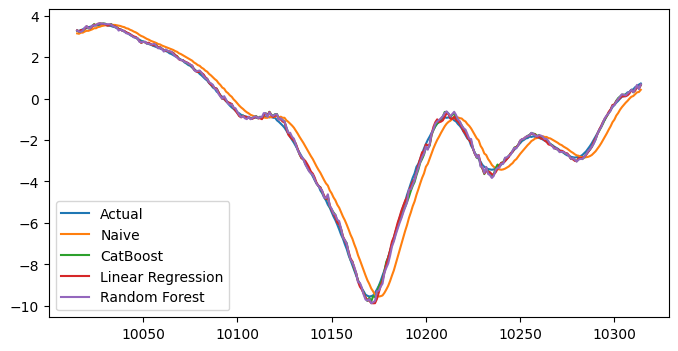

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(df2_test['OptPow'][:300], label='Actual') # Actual
plt.plot(predictions_naive[:300], label='Naive')   # Naive
plt.plot(predictions_cb[:300], label='CatBoost')   # CatBoost
plt.plot(predictions_lr[:300], label='Linear Regression')  # Linear Regression
plt.plot(predictions_rf[:300], label='Random Forest')  # Linear Regression
plt.legend()

print(f"RMSE of Naive: {rmse(df2_test['OptPow'],predictions_naive)}")
print(f"RMSE of LR: {rmse(df2_test['OptPow'],predictions_lr)}")
print(f"RMSE of CB: {rmse(df2_test['OptPow'],predictions_cb)}")
print(f"RMSE of RF: {rmse(df2_test['OptPow'],predictions_rf)}")


In [28]:
print("Feature Importance in Linear Regression:")
for feature_name, importance in zip(feature_columns, model_lr.coef_):
    print(feature_name, ":", importance)

print("Feature Importance in CatBoost:")
for feature_name, importance in zip(feature_columns, model_cb.feature_importances_):
    print(feature_name, ":", importance)

Feature Importance in Linear Regression:
OptPow_diff_lag5 : 2.678165355546124
OptPow_diff_lag6 : 3.6704735237806134
OptPow_diff_lag7 : 1.7732617751139659
OptPow_diff_lag8 : 0.47139424081196735
OptPow_diff_lag9 : -1.185566977861988
OptPow_diff_lag10 : -2.0176454199532694
OptPow_diff_lag11 : -1.2982810617905645
OptPow_diff_lag12 : -0.5227158997261082
OptPow_diff_lag13 : 0.4266864853709199
OptPow_diff_lag14 : 0.4238113824870471
Feature Importance in CatBoost:
OptPow_diff_lag5 : 41.350479039826666
OptPow_diff_lag6 : 32.296554998576205
OptPow_diff_lag7 : 6.671891859410472
OptPow_diff_lag8 : 2.7060092818065375
OptPow_diff_lag9 : 1.3494563997585185
OptPow_diff_lag10 : 2.1002072175021476
OptPow_diff_lag11 : 1.8900593011963376
OptPow_diff_lag12 : 2.1620657131123004
OptPow_diff_lag13 : 3.2079368543547746
OptPow_diff_lag14 : 6.265339334456038


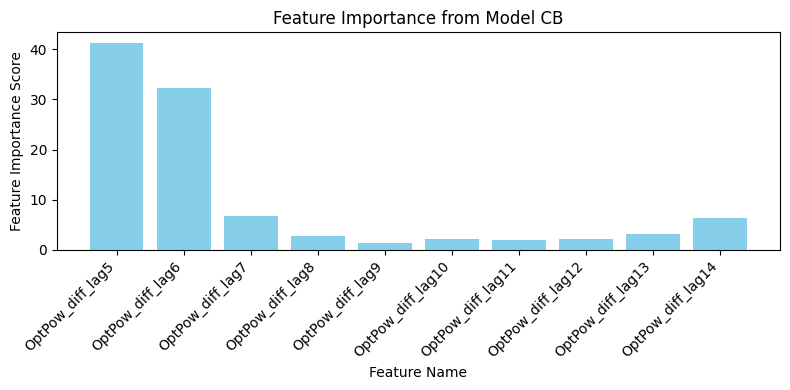

In [29]:

features = []
importances = []

for feature_name, importance in zip(feature_columns, model_cb.feature_importances_):
    features.append(feature_name)
    importances.append(importance)

# 2. Create the Bar Chart
plt.figure(figsize=(8, 4))

# Use plt.bar() to create the visualization
plt.bar(features, importances, color='skyblue')

# Add labels and title for clarity
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance Score")
plt.title("Feature Importance from Model CB")

# Rotate feature labels for better readability if names are long
plt.xticks(rotation=45, ha='right')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

**TESTING/PREDICTION, FOR RANGE OF LATENCIES**

In [30]:
# Repeat for a range of latencies
test_latencies = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50]

rmse_naive = []
rmse_lr = []
rmse_cb = []
rmse_rf = []

var_cb = []
var_lr = []
var_naive = []
var_rf = []
var_input = []

p_cb = []
p_lr = []
p_naive = []
p_rf = []

for latency in test_latencies:
  df2 = df.copy()

  # Adding the diff steps
  df2['OptPow_diff'] = df2['OptPow'].diff()

  # Adding lagged features
  for lag in range(latency,latency+nTaps):
    df2['OptPow_diff_lag' + str(lag)] = df2['OptPow_diff'].shift(lag)

  # Adding the target variable, the step nTaps samples from now:
  df2['OptPow_lag'+str(latency)] = df2['OptPow'].shift(latency)

  df2['OptPow_'+str(latency)+'stepdiff_target'] = df2['OptPow']-df2['OptPow_lag'+str(latency)]

  # Dropping invalid rows due to lags
  df2.dropna(inplace=True)


  # Split train/test
  #test_size=0.2
  #df2_train = df2[:round((1-test_size)*len(df2))]
  #df2_test = df2[round((1-test_size)*len(df2)):]

  # Use Train and Test samples similar to LMS
  nTrain = 10000
  nTest = 10000
  df2_train = df2[:nTrain]
  df2_test = df2[nTrain:]

  # Define the feature columns and target column
  feature_columns = ['OptPow_diff_lag'+str(i) for i in range(latency,latency+nTaps)]
  target_column = 'OptPow_'+str(latency)+'stepdiff_target'

  # Separate the features and target variables
  X_train = df2_train[feature_columns]
  y_train = df2_train[target_column]
  X_test = df2_test[feature_columns]
  y_test = df2_test[target_column]


  # Test Naive (this assumes the prediction is equal to the last value)
  predictions_naive = df2_test['OptPow_lag'+str(latency)]


  # TRAIN & TEST LINEAR REGRESSION
  model_lr.fit(X_train, y_train)
  predictions_lr = model_lr.predict(X_test)+df2_test['OptPow_lag'+str(latency)]


  # TRAIN & TEST CATBOOST
  model_cb.fit(X_train, y_train)

  predictions_cb = model_cb.predict(X_test)+df2_test['OptPow_lag'+str(latency)]


  # TRAIN & TEST RANDOM FOREST
  model_r_forest.fit(X_train, y_train)
  predictions_rf = model_r_forest.predict(X_test)+df2_test['OptPow_lag'+str(latency)]



  # Evaluate RMSE
  rmse_naive +=[rmse(df2_test['OptPow'],predictions_naive)]
  rmse_lr +=[rmse(df2_test['OptPow'],predictions_lr)]
  rmse_cb +=[rmse(df2_test['OptPow'],predictions_cb)]
  rmse_rf +=[rmse(df2_test['OptPow'],predictions_rf)]


  # Pre-compensate power.
  precom_cb = df2_test['OptPow'] - predictions_cb # Catboost
  precom_lr = df2_test['OptPow'] - predictions_lr # Linear Regression
  precom_naive = df2_test['OptPow'] - predictions_naive # Naive
  precom_rf = df2_test['OptPow'] - predictions_rf # Random Forest

  # Variance of Pre-compensated power
  var_cb += [np.var(precom_cb)]
  var_lr += [np.var(precom_lr)]
  var_naive += [np.var(precom_naive)]
  var_rf += [np.var(precom_rf)]
  var_input = np.var(df2_test['OptPow'])

  p_cb += [precom_cb]
  p_lr += [precom_lr]
  p_naive += [precom_naive]
  p_rf += [precom_rf]


EVALUATION METRICS

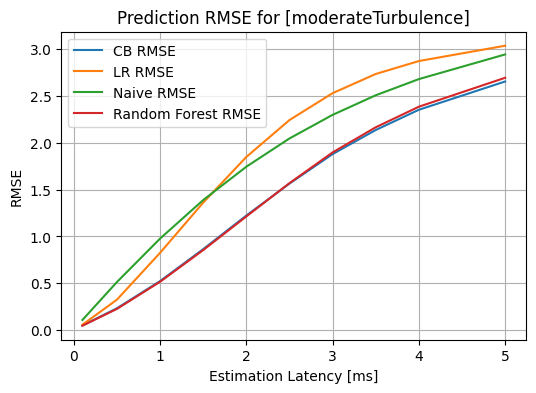

In [31]:
# Plot RMSE

plt.figure(figsize=(6, 4))
# plt.axhline(y=var_input, label='Input Variance', linestyle='--')

tl = np.array(test_latencies)/10

plt.plot(tl, rmse_cb, label='CB RMSE')
plt.plot(tl, rmse_lr, label='LR RMSE')
plt.plot(tl, rmse_naive, label='Naive RMSE')
plt.plot(tl, rmse_rf, label='Random Forest RMSE')
plt.legend()
plt.xlabel('Estimation Latency [ms]')
plt.ylabel('RMSE')
plt.title('Prediction RMSE for [' + turb + 'Turbulence]');
plt.grid()

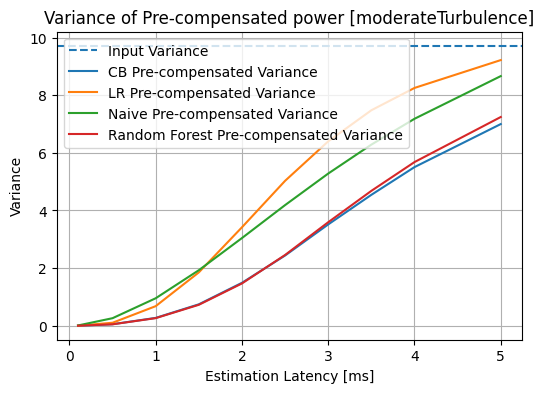

In [32]:
# Plot VARIANCE

plt.figure(figsize=(6, 4))
plt.axhline(y=var_input, label='Input Variance', linestyle='--')

plt.plot(tl, var_cb, label='CB Pre-compensated Variance')
plt.plot(tl, var_lr, label='LR Pre-compensated Variance')
plt.plot(tl, var_naive, label='Naive Pre-compensated Variance')
plt.plot(tl, var_rf, label='Random Forest Pre-compensated Variance')
plt.legend()
plt.xlabel('Estimation Latency [ms]')
plt.ylabel('Variance')
plt.title('Variance of Pre-compensated power [' + turb + 'Turbulence]');
plt.grid()

Let's add some more features to the DataFrame to potentially improve the model's performance. We can include moving averages and exponential smoothing.

In [33]:
# Add moving averages
window_sizes = [5, 10, 20]  # Example window sizes
for window in window_sizes:
    df2['OptPow_moving_avg_' + str(window)] = df2['OptPow'].rolling(window=window).mean()
    if use_diff:
        df2['OptPow_diff_moving_avg_' + str(window)] = df2['OptPow_diff'].rolling(window=window).mean()

# Add exponential smoothing
alpha_values = [0.1, 0.5] # Example alpha values
for alpha in alpha_values:
    df2['OptPow_exp_smoothing_' + str(alpha)] = df2['OptPow'].ewm(alpha=alpha).mean()
    if use_diff:
         df2['OptPow_diff_exp_smoothing_' + str(alpha)] = df2['OptPow_diff'].ewm(alpha=alpha).mean()


# Dropping invalid rows due to new features
df2.dropna(inplace=True)

# Display the updated DataFrame head
display(df2.head())

,OptPow,OptPow_diff,OptPow_diff_lag50,OptPow_diff_lag51,OptPow_diff_lag52,OptPow_diff_lag53,OptPow_diff_lag54,OptPow_diff_lag55,OptPow_diff_lag56,OptPow_diff_lag57,...,OptPow_moving_avg_5,OptPow_diff_moving_avg_5,OptPow_moving_avg_10,OptPow_diff_moving_avg_10,OptPow_moving_avg_20,OptPow_diff_moving_avg_20,OptPow_exp_smoothing_0.1,OptPow_diff_exp_smoothing_0.1,OptPow_exp_smoothing_0.5,OptPow_diff_exp_smoothing_0.5
79,2.316573,-0.0178,0.0534,0.0534,0.0712,0.0534,0.0712,0.0712,0.0890,0.0534,...,2.359293,-0.02136,2.423373,-0.02670,2.588913,-0.03382,2.484173,-0.029024,2.337085,-0.020513
80,2.298773,-0.0178,0.0534,0.0534,0.0534,0.0712,0.0534,0.0712,0.0712,0.0890,...,2.337933,-0.02136,2.398453,-0.02492,2.557763,-0.03115,2.463355,-0.027764,2.317929,-0.019156
81,2.280973,-0.0178,0.0356,0.0534,0.0534,0.0534,0.0712,0.0534,0.0712,0.0712,...,2.316573,-0.02136,2.375313,-0.02314,2.526613,-0.03115,2.443125,-0.026658,2.299451,-0.018478
82,2.280973,0.0000,0.0356,0.0356,0.0534,0.0534,0.0534,0.0712,0.0534,0.0712,...,2.302333,-0.01424,2.353953,-0.02136,2.498133,-0.02848,2.425333,-0.023733,2.290212,-0.009239
83,2.263173,-0.0178,0.0178,0.0356,0.0356,0.0534,0.0534,0.0534,0.0712,0.0534,...,2.288093,-0.01424,2.334373,-0.01958,2.470543,-0.02759,2.407711,-0.023089,2.276692,-0.013520


In [34]:

all_precom_cb = {}  # Store the pre-compensated power values for different latencies

for latency, precom_values in zip(test_latencies, p_cb):
    # Store pre-compensated power values for the current latency in the dict using the latency as the key
    all_precom_cb[latency] = precom_values.fillna(-9999).astype('float64')

# Create the final DataFrame from the dictionary
final_df = pd.DataFrame(all_precom_cb)

# final_df['nTaps'] = nTaps
# Save to CSV

name = turb+'_precom_cb_matlab.csv'

# final_df.to_csv(name, index=False)
# print('Saved!')


In [35]:
# Create a DataFrame for predictions and actual values
predictions_df = pd.DataFrame({
    'Actual': df2_test['OptPow'],
    'Naive': predictions_naive,
    'Linear Regression': predictions_lr,
    'CatBoost': predictions_cb})

# Save to CSV

nome = turb+'_turb_predictions.csv'

# predictions_df.to_csv(nome, index=False)

In [36]:
# Create a DataFrame for the RMSE results
rmse_results = pd.DataFrame({'Latency': test_latencies,
                             'Naive': rmse_naive,
                             'Linear Regression': rmse_lr,
                             'CatBoost': rmse_cb})

# Save the DataFrame to a CSV file
results_nome = turb+'_turb_rmse_results.csv'

# rmse_results.to_csv(results_nome, index=False)

In [37]:
# #  Create the filenames to save to
#   fylname = 'wan_'+turb+'_turb_df2.csv'

# # fylname = 'wan_'+turb+'_turb_df2.csv'
# df2.to_csv(fylname)







In [38]:
# import pandas as pd


# # Create a simple series from 1 to 20
# data = pd.Series(range(1, 21))
# # print("Original Series (1 to 20):")
# # print(data)

# # Define the lag values for features (samples 1-5 to predict sample 10, etc.)
# # This means features are lagged by 5, 6, 7, 8, and 9 steps
# feature_lag_start = 3
# feature_lag_end = 6
# feature_lag_values = range(feature_lag_start, feature_lag_end +0)

# # Create an empty DataFrame to store lagged series
# lagged_df = pd.DataFrame(data, columns=['Target'])

# # Apply lagging for each feature lag value and add as a new column
# for lag in feature_lag_values:
#     lagged_df[f'feature_lag_{lag}'] = data.shift(lag)

# # lagged_df['Target'] = lagged_df.shift(3)
# # The target variable is the original data after dropping rows with NaNs
# # This is implicitly represented by the 'Original' column in the rows that remain after dropping NaNs

# print("\nDataFrame with lagged features (5 to 9) and 'Original' column (representing target after dropping NaNs):")
# # display(lagged_df)

# # Show the DataFrame after dropping NaNs to illustrate the effective target
# print("\nDataFrame after dropping NaNs (illustrating effective features and target):")
# display(lagged_df.dropna())
# # display(lagged_df)


